In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid

from pyproj import Geod


from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Input data
kitchen = pd.read_csv("input/kitchen.csv", error_bad_lines=False, engine="python", encoding = "ISO-8859-1")
customer = pd.read_csv("input/customer.csv", error_bad_lines=False, engine="python", encoding = "ISO-8859-1")

customer1 = pd.read_csv("input/customer.csv", error_bad_lines=False, engine="python", encoding = "ISO-8859-1")
kitchen1 = pd.read_csv("input/kitchen.csv", error_bad_lines=False, engine="python", encoding = "ISO-8859-1")


In [3]:
import bokeh.plotting as bk
from bokeh.plotting import figure, show, output_file

bk.output_notebook()


def mscatter(p, x, y, marker):
    p.scatter(x, y, marker=marker, size=10,
              line_color="black", fill_color="red", alpha=0.5)
    

p = figure(title="Persebaran Customer dan Kitchen")
p.grid.grid_line_color = None
p.background_fill_color = "#eeeeee"
#p.axis.visible = False

mscatter(p, customer['long'], customer['lat'], "circle")
mscatter(p, kitchen['long'], kitchen['lat'], "x")



show(p)

Loading BokehJS ...

In [4]:
# Preprocessing for grouping
kitchen.drop(['minCapacity'], axis=1, inplace=True)
kitchen.drop(['maxCapacity'], axis=1, inplace=True)
kitchen.drop(['tolerance'], axis=1, inplace=True)

customer.drop(['customersName'], axis=1, inplace=True)
customer.drop(['qtyOrdered'], axis=1, inplace=True)


lef = preprocessing.LabelEncoder()

#Create a new column with transformed values.
kitchen['kitchenName'] = lef.fit_transform(kitchen['kitchenName'])
print(kitchen)



   kitchenName        long       lat
0            0  106.814653 -6.150735
1            1  106.834772 -6.279489
2            2  106.793820 -6.192896
3            3  106.826822 -6.224094
4            4  106.795993 -6.157473
5            5  106.847226 -6.184124
6            6  106.914214 -6.256911


# Overview
Kunci utama dari Efisiensi pengiriman adalah customer harus terassign ke kitchen yang terdekat dulu.
Kami melakukannya dengan menSort customer dari jarak yang paling jauh dari titik pusat customer (sum/total lat long).
Solusi tersebut belum optimal,tapi mendekati.
Solusi optimal = Sort dari Outermost customer.
Customer kemudian di assign ke kitchen terdekatnya, apabila sudah full maka diassign ke kitchen kedua terdekat, dst.
Sehingga bisa didapat group berupa customer yang terassign ke suatu kitchen.

Driver kemudian di assign per group berdasarkan degree dan jarak.
Di assign tidak hanya berdasarkan jarak untuk mengoptimalkan waktu pengiriman selama 1 jam.

# Grouping customer to the best kitchen

In [5]:
# Find center point of customer, buat nyari
# long
long_centroid = sum(customer['long'])/len(customer)
# lat
lat_centroid = sum(customer['lat'])/len(customer)

In [6]:
import bokeh.plotting as bk
from bokeh.plotting import figure, show, output_file

bk.output_notebook()


def mscatter(p, x, y, marker,color):
    p.scatter(x, y, marker=marker, size=10,
              line_color="black", fill_color=color, alpha=0.5)
    

p = figure(title="Persebaran Customer dan Kitchen")
p.grid.grid_line_color = None
p.background_fill_color = "#eeeeee"
#p.axis.visible = False

mscatter(p, customer['long'], customer['lat'], "circle", "red")
mscatter(p, long_centroid, lat_centroid, "square", "blue")



show(p)

Loading BokehJS ...

In [7]:
wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method katanya

#Get distance between pairs of lat-lon points
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
  return dist



#Add/update a column to the data frame with the distances (in metres)
customer1['dist0'] = Distance(customer1['lat'].tolist(),customer1['long'].tolist(),[kitchen['lat'].iloc[0]]*len(customer),[kitchen['long'].iloc[0]]*len(customer))
customer1['dist1'] = Distance(customer1['lat'].tolist(),customer1['long'].tolist(),[kitchen['lat'].iloc[1]]*len(customer),[kitchen['long'].iloc[1]]*len(customer))
customer1['dist2'] = Distance(customer1['lat'].tolist(),customer1['long'].tolist(),[kitchen['lat'].iloc[2]]*len(customer),[kitchen['long'].iloc[2]]*len(customer))
customer1['dist3'] = Distance(customer1['lat'].tolist(),customer1['long'].tolist(),[kitchen['lat'].iloc[3]]*len(customer),[kitchen['long'].iloc[3]]*len(customer))
customer1['dist4'] = Distance(customer1['lat'].tolist(),customer1['long'].tolist(),[kitchen['lat'].iloc[4]]*len(customer),[kitchen['long'].iloc[4]]*len(customer))
customer1['dist5'] = Distance(customer1['lat'].tolist(),customer1['long'].tolist(),[kitchen['lat'].iloc[5]]*len(customer),[kitchen['long'].iloc[5]]*len(customer))
customer1['dist6'] = Distance(customer1['lat'].tolist(),customer1['long'].tolist(),[kitchen['lat'].iloc[6]]*len(customer),[kitchen['long'].iloc[6]]*len(customer))

# Minimum distance
#customer1['Minimum'] = customer1.loc[:, ['dist0', 'dist1', 'dist2', 'dist3', 'dist4', 'dist5', 'dist6']].min(axis=1)

a = pd.DataFrame(np.sort(customer1[['dist0','dist1','dist2','dist3','dist4','dist5','dist6']].values)[:,:3], columns=['nearest','2nearest', '3nearest'])
customer1 = customer1.join(a)
customer1.head()

,customersName,long,lat,qtyOrdered,dist0,dist1,dist2,dist3,dist4,dist5,dist6,nearest,2nearest,3nearest
0,53WJWGRK,106.836794,-6.217340,5,7762.611478,6876.529001,5470.492239,1332.632595,8013.928011,3850.423414,9620.545239,1332.632595,3850.423414,5470.492239
1,34JD8T7P,106.824099,-6.183299,9,3749.915562,10702.701172,3515.123220,4521.475448,4223.027168,2561.228658,12873.530598,2561.228658,3515.123220,3749.915562
2,1FD97O63,106.820074,-6.203792,5,5898.053090,8527.656605,3145.475060,2366.144978,5774.203801,3709.584694,11960.161919,2366.144978,3145.475060,3709.584694
3,39R7P6D7,106.912387,-6.205225,1,12382.173772,11883.573586,13192.714705,9696.567805,13922.477780,7579.764711,5719.405284,5719.405284,7579.764711,9696.567805
4,4E74CSUP,106.708647,-6.169678,3,11918.385945,18501.203552,9770.166603,14396.895178,9761.221806,15420.549063,24710.933461,9761.221806,9770.166603,11918.385945


436

In [8]:
print(kitchen1)

             kitchenName        long       lat  minCapacity  maxCapacity  \
0             Dapur Miji  106.814653 -6.150735           50          100   
1        Dapur Nusantara  106.834772 -6.279489           30           40   
2       Familia Catering  106.793820 -6.192896           50           60   
3           Pondok Rawon  106.826822 -6.224094           50           70   
4          Rose Catering  106.795993 -6.157473           70           80   
5  Tiga Kitchen Catering  106.847226 -6.184124           30           50   
6             Ummu Uwais  106.914214 -6.256911           20           50   

   tolerance  
0        105  
1         45  
2         65  
3         75  
4         85  
5         55  
6         55  


In [9]:
# Find distance from customer point to central customer point
customer1['distSort'] = Distance(customer1['lat'].tolist(),customer1['long'].tolist(),[lat_centroid]*len(customer),[lat_centroid]*len(customer))
#np.sqrt( (customer.long-long_centroid)**2 + (customer.lat-lat_centroid)**2)

# Sort by longest distance
customer1 = customer1.sort_values(['distSort'], ascending=False)

In [10]:
customer1.reset_index(drop=True, inplace=True)
customer1.head()

,customersName,long,lat,qtyOrdered,dist0,dist1,dist2,dist3,dist4,dist5,dist6,nearest,2nearest,3nearest,distSort
0,8B9S30VE,106.914584,-6.188593,1,11826.176802,13381.038701,13373.947862,10476.178670,13569.185535,7471.283592,7555.248925,7471.283592,7555.248925,10476.178670,1.248141e+07
1,4GAA84UO,106.917938,-6.223125,1,13955.599924,11115.405070,14137.160441,10084.163107,15325.201640,8935.711220,3759.000476,3759.000476,8935.711220,10084.163107,1.248116e+07
2,39R7P6D7,106.912387,-6.205225,1,12382.173772,11883.573586,13192.714705,9696.567805,13922.477780,7579.764711,5719.405284,5719.405284,7579.764711,9696.567805,1.248087e+07
3,2NI8PFRH,106.893353,-6.114339,5,9596.006385,19380.068250,14029.827477,14196.559151,11784.981637,9253.265823,15934.820773,9253.265823,9596.006385,11784.981637,1.248042e+07
4,2HV6K6KS,106.894592,-6.146279,4,8861.618248,16150.476685,12287.079812,11415.294194,10983.186774,6708.090354,12425.773557,6708.090354,8861.618248,10983.186774,1.247998e+07


In [24]:
# Data already sorted from outermost customer 
# For each row in the column,assign customer to the the nearest kitchen, 
# if the kitchen already full, assign customer to the second nearest kitchen and so on.

# BELUM SELESAI YANG INI
clusters = []
#masih manual
cap0 = 0
cap1 = 0
cap2 = 0
cap3 = 0
cap4 = 0
cap5 = 0
cap6 = 0

cluster=8 #hanya init
scndCluster=8 #hanya init

for i in customer1.index:
    if customer1['nearest'].loc[i]==customer1['dist0'].loc[i]:
        cluster=0
    elif customer1['nearest'].loc[i]==customer1['dist1'].loc[i]:
        cluster=1
    elif customer1['nearest'].loc[i]==customer1['dist2'].loc[i]:
        cluster=2
    elif customer1['nearest'].loc[i]==customer1['dist3'].loc[i]:
        cluster=3
    elif customer1['nearest'].loc[i]==customer1['dist4'].loc[i]:
        cluster=4
    elif customer1['nearest'].loc[i]==customer1['dist5'].loc[i]:
        cluster=5
#    if customer1['nearest'].loc[i]==customer1['dist6'].loc[i]:
#        cluster=6
        
    if customer1['2nearest'].loc[i]==customer1['dist0'].loc[i]:
        scndCluster=0
    elif customer1['2nearest'].loc[i]==customer1['dist1'].loc[i]:
        scndCluster=1
    elif customer1['2nearest'].loc[i]==customer1['dist2'].loc[i]:
        scndCluster=2
    elif customer1['2nearest'].loc[i]==customer1['dist3'].loc[i]:
        scndCluster=3
    elif customer1['2nearest'].loc[i]==customer1['dist4'].loc[i]:
        scndCluster=4
    elif customer1['2nearest'].loc[i]==customer1['dist5'].loc[i]:
        scndCluster=5
#    if customer1['2nearest'].loc[i]==customer1['dist6'].loc[i]:
#        scndCluster=6

    if customer1['3nearest'].loc[i]==customer1['dist0'].loc[i]:
        trdCluster=0
    elif customer1['3nearest'].loc[i]==customer1['dist1'].loc[i]:
        trdCluster=1
    elif customer1['3nearest'].loc[i]==customer1['dist2'].loc[i]:
        trdCluster=2
    elif customer1['3nearest'].loc[i]==customer1['dist3'].loc[i]:
        trdCluster=3
    elif customer1['3nearest'].loc[i]==customer1['dist4'].loc[i]:
        trdCluster=4
    elif customer1['3nearest'].loc[i]==customer1['dist5'].loc[i]:
        trdCluster=5
#    if customer1['3nearest'].loc[i]==customer1['dist6'].loc[i]:
#        trdCluster=6

# Assign to nearest kitchen if not yet full
    if (cluster==0) and (cap0<100):
        cap0=cap0+customer1['qtyOrdered'].loc[i]
    elif (cluster==1) and (cap1<40):
        cap1=cap1+customer1['qtyOrdered'].loc[i]
    elif (cluster==2) and (cap2<60):
        cap2=cap2+customer1['qtyOrdered'].loc[i]
    elif (cluster==3) and (cap3<70):
        cap3=cap3+customer1['qtyOrdered'].loc[i]
    elif (cluster==4) and (cap4<80):
        cap4=cap4+customer1['qtyOrdered'].loc[i]
    elif (cluster==5) and (cap5<50):
        cap5=cap5+customer1['qtyOrdered'].loc[i]
    elif (cluster==6) and (cap6<50):
        cap6=cap6+customer1['qtyOrdered'].loc[i]

# if full assign to 2nd nearest kitchen
    if (cluster==0) and (cap0>100):
        cluster=scndCluster
        scndCluster=10
    elif (cluster==1) and (cap1>40):
        cluster=scndCluster
        scndCluster=10
    elif (cluster==2) and (cap2>60):
        cluster=scndCluster
        scndCluster=10
    elif (cluster==3) and (cap3>70):
        cluster=scndCluster
        scndCluster=10
    elif (cluster==4) and (cap4>80):
        cluster=scndCluster
        scndCluster=10
    elif (cluster==5) and (cap5>50):
        cluster=scndCluster
        scndCluster=10
    elif (cluster==6) and (cap6>50):
        cluster=scndCluster
        scndCluster=10
    
# if 2nd nearest also full assign to 3rd nearest
#
#    if (cluster==0) and (cap0>100) and (scndCluster==10):
#        cluster=trdCluster
#        trdCluster=10
#    if (cluster==1) and (cap1>40) and (scndCluster==10):
#        cluster=trdCluster
#        trdCluster=10
#    if (cluster==2) and (cap2>60):
#        cluster=trdCluster
#        trdCluster=10
#    if (cluster==3) and (cap3>70):
#        cluster=trdCluster
#        trdCluster=10
#    if (cluster==4) and (cap4>80):
#        cluster=trdCluster
#        trdCluster=10
#    if (cluster==5) and (cap5>50):
#        cluster=trdCluster
#        trdCluster=10
#    if (cluster==6) and (cap6>50):
#        cluster=trdCluster
#        trdCluster=10

# count if 2nd nearest

    if (cluster==0) and (scndCluster==10) and (trdCluster!=10):
        cap0=cap0+customer1['qtyOrdered'].loc[i]
    elif (cluster==1) and (scndCluster==10) and (trdCluster!=10):
        cap1=cap1+customer1['qtyOrdered'].loc[i]
    elif (cluster==2) and (scndCluster==10) and (trdCluster!=10):
        cap2=cap2+customer1['qtyOrdered'].loc[i]
    elif (cluster==3) and (scndCluster==10) and (trdCluster!=10):
        cap3=cap3+customer1['qtyOrdered'].loc[i]
    elif (cluster==4) and (scndCluster==10) and (trdCluster!=10):
        cap4=cap4+customer1['qtyOrdered'].loc[i]
    elif (cluster==5) and (scndCluster==10) and (trdCluster!=10):
        cap5=cap5+customer1['qtyOrdered'].loc[i]
    elif (cluster==6) and (scndCluster==10) and (trdCluster!=10):
        cap6=cap6+customer1['qtyOrdered'].loc[i]

# count if 3rd nearest
#
#    if (cluster==0) and (scndCluster==10) and (trdCluster==10):
#        cap0=cap0+customer1['qtyOrdered'].loc[i]
#    if (cluster==1) and (scndCluster==10) and (trdCluster==10):
#        cap1=cap1+customer1['qtyOrdered'].loc[i]
#    if (cluster==2) and (scndCluster==10) and (trdCluster==10):
#        cap2=cap2+customer1['qtyOrdered'].loc[i]
#    if (cluster==3) and (scndCluster==10) and (trdCluster==10):
#        cap3=cap3+customer1['qtyOrdered'].loc[i]
#    if (cluster==4) and (scndCluster==10) and (trdCluster==10):
#        cap4=cap4+customer1['qtyOrdered'].loc[i]
#    if (cluster==5) and (scndCluster==10) and (trdCluster==10):
#        cap5=cap5+customer1['qtyOrdered'].loc[i]
#    if (cluster==6) and (scndCluster==10) and (trdCluster==10):
#        cap6=cap6+customer1['qtyOrdered'].loc[i]
    
    clusters.append(cluster)       
     
    
customer1['cluster'] = clusters
print(cap0+cap1+cap2+cap3+cap4+cap5) 

293


In [27]:
customer1['qtyOrdered'].sum()

436

In [12]:
customer1.head()

,customersName,long,lat,qtyOrdered,dist0,dist1,dist2,dist3,dist4,dist5,dist6,nearest,2nearest,3nearest,distSort,cluster
0,8B9S30VE,106.914584,-6.188593,1,11826.176802,13381.038701,13373.947862,10476.178670,13569.185535,7471.283592,7555.248925,7471.283592,7555.248925,10476.178670,1.248141e+07,5
1,4GAA84UO,106.917938,-6.223125,1,13955.599924,11115.405070,14137.160441,10084.163107,15325.201640,8935.711220,3759.000476,3759.000476,8935.711220,10084.163107,1.248116e+07,5
2,39R7P6D7,106.912387,-6.205225,1,12382.173772,11883.573586,13192.714705,9696.567805,13922.477780,7579.764711,5719.405284,5719.405284,7579.764711,9696.567805,1.248087e+07,5
3,2NI8PFRH,106.893353,-6.114339,5,9596.006385,19380.068250,14029.827477,14196.559151,11784.981637,9253.265823,15934.820773,9253.265823,9596.006385,11784.981637,1.248042e+07,5
4,2HV6K6KS,106.894592,-6.146279,4,8861.618248,16150.476685,12287.079812,11415.294194,10983.186774,6708.090354,12425.773557,6708.090354,8861.618248,10983.186774,1.247998e+07,5


In [13]:
# Data visulization customer assigned to its kitchen

def visualize(data):
    x = data['long']
    y = data['lat']
    Cluster = data['cluster'] 

    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(x,y,c=Cluster, cmap=plt.cm.Paired, s=10, label='customer')
    ax.scatter(kitchen['long'],kitchen['lat'], s=10, c='r', marker="x", label='second')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    plt.colorbar(scatter)

    fig.show()

In [14]:
# Visualization Example customer assigned to kitchen (without following constraint)
# THIS IS ONLY EXAMPLE
#y = kitchen['kitchenName']
#X = pd.DataFrame(kitchen.drop('kitchenName', axis=1))

#clf = NearestCentroid()
#clf.fit(X, y)
#pred = clf.predict(customer)

#customer1['cluster'] = pd.Series(pred, index=customer1.index)
#customer['cluster'] = pd.Series(pred, index=customer.index)

/home/ken/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


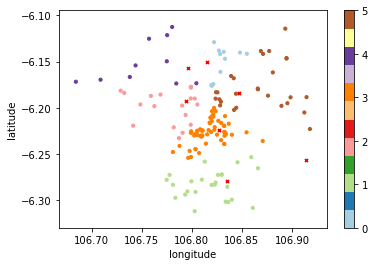

In [15]:
visualize(customer1)

In [16]:
# Count customer order assigned to Kitchen
dapurMiji = (customer1.where(customer1['cluster'] == 0))['qtyOrdered'].sum()
dapurNusantara = (customer1.where(customer1['cluster'] == 1))['qtyOrdered'].sum()
familiaCatering = (customer1.where(customer1['cluster'] == 2))['qtyOrdered'].sum()
pondokRawon = (customer1.where(customer1['cluster'] == 3))['qtyOrdered'].sum()
roseCatering = (customer1.where(customer1['cluster'] == 4))['qtyOrdered'].sum()
tigaKitchenCatering = (customer1.where(customer1['cluster'] == 5))['qtyOrdered'].sum()
ummuUwais = (customer1.where(customer1['cluster'] == 6))['qtyOrdered'].sum()

d = {'Dapur Miji': dapurMiji , 'Dapur Nusantara': dapurNusantara, 'Familia Catering': familiaCatering, 'Pondok Rawon': pondokRawon,'Rose Catering': roseCatering, 'Tiga Kitchen Catering': tigaKitchenCatering, 'Ummu Uwais': ummuUwais}

In [17]:
print(customer1.cluster.value_counts())

3    66
5    27
1    25
2    19
0    11
4    10
Name: cluster, dtype: int64


In [18]:
# Print sum of assigned
print(d) 

{'Dapur Miji': 31.0, 'Dapur Nusantara': 68.0, 'Familia Catering': 59.0, 'Pondok Rawon': 175.0, 'Rose Catering': 41.0, 'Tiga Kitchen Catering': 62.0, 'Ummu Uwais': 0.0}


In [19]:
print(kitchen1)

             kitchenName        long       lat  minCapacity  maxCapacity  \
0             Dapur Miji  106.814653 -6.150735           50          100   
1        Dapur Nusantara  106.834772 -6.279489           30           40   
2       Familia Catering  106.793820 -6.192896           50           60   
3           Pondok Rawon  106.826822 -6.224094           50           70   
4          Rose Catering  106.795993 -6.157473           70           80   
5  Tiga Kitchen Catering  106.847226 -6.184124           30           50   
6             Ummu Uwais  106.914214 -6.256911           20           50   

   tolerance  
0        105  
1         45  
2         65  
3         75  
4         85  
5         55  
6         55  


# Assign driver in group based on degree and distance

In [20]:
# Get degree for each customer in the cluster

def getDegree(data):
    # distance
    # center long lat (start of routing)
    center_latitude = #Tiap Kitchen
    center_longitude = #Tiap Kitchen
    degrees = []
    degree = 0
    # For each row in the column,
    for row in data['longitude']:
        degrees = np.rint(np.rad2deg(np.arctan2((data['latitude']-center_latitude),(data['longitude']-center_longitude))))
       #center di pulogadung
    data['degrees'] = degrees
    return data

SyntaxError: invalid syntax (<ipython-input-20-c88edd49c886>, line 6)

In [ ]:
# Assign driver dari kitchen ke customer berdasarkan degree dan jarak
# Priority utama berdasarkan degree jadi gaada driver yang deket doang
# Tapi belum dipikir gimana bisa optimize waktu harus satu jam max, tapi seenggaknya driver udah agak rata jaraknya
# Kasus khusus apabila yg degree nya kecil jaraknya jauh banget, dia driver baru.

# BELUM SELESAI YANG INI